## Trip Advisor: Analyzing and Clustering German Cities
##### by Tobias (https://github.com/TobiasGuggemos), May 2020.

[1. Intro](#1.-Intro)

[2. Data](#2.-Data)

[3. Data Analysis](#3.-Data-Analysis)

---------

### 1. Intro
Background: Capstone Project of e-learning course on Coursera about Applied Data Science (Part 1&2).

Project: This Notebook is about German cities. The goal is to support decisions about the next spot for a city trip. Potential stakeholders are all people interested in city trips in Germany. We will cluster the cities based on the venues near to the city centre. This will help to choose an appropriate spot for the next city depending on the purpose of the trip and the interest in different venue types. The city clusters can be used to find similar cities to already visited and much appreciated cities and trips.       






### 2. Data

First, we want to identify the largest cities in Germany. Therefore we will use a list on wikipedia of large german cities, large defined as: with a population of min 100k. For all of these cities we need to list the venues around the city center. We will use Foursquare API and Get Venue Recommendations for a given place. Furthermore, let's define the number of requested venues per city and test/start with 100. We consider venues within a circle with a radius of 2,000m around the city center. For the city clustering we also need to know the venue category. This data is also collected via Foursquare.   
For this, we need to have all the city latitude and longitude coordinates which we can also explore on wikipedia, some other web pages or we will use Geocoding libraries for Python, e.g. Geopy. 




In [1]:
!pip install "ipython-beautifulsoup[bs4]"
#!pip install lxml
from bs4 import BeautifulSoup
import requests


     |████████████████████████████████| 112kB 7.3MB/s eta 0:00:01


-----
Let's go to wikipedia and read out the largest cities in Germany with the help of BeautifulSoup.

We save them into a DataFrame and print the Top 6:


In [2]:
import pandas as pd

link='https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population'
cities=[]

source = requests.get(link).text
soup = BeautifulSoup(source, 'html.parser')

table = soup.find('tbody')

rows=table.find_all('tr')
for row in rows[1:len(rows)]:
    a=row.find('a')
    cities.append(a.text)

df=pd.DataFrame({'city':cities})    
df.head(6)


,city
0,Berlin
1,Hamburg
2,Munich
3,Cologne
4,Frankfurt am Main
5,Stuttgart


For each city we get the geo coordinates via geopy and save them to the dataframe:

In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

latitude=[]
longitude=[]

geolocator = Nominatim(user_agent="test")
for city in cities:
    location = geolocator.geocode(city)
    lat = location.latitude
    lng = location.longitude
    latitude.append(lat)
    longitude.append(lng)

df['latitude']=latitude
df['longitude']=longitude
df
    
    

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

,city,latitude,longitude
0,Berlin,52.517037,13.388860
1,Hamburg,53.543764,10.009913
2,Munich,48.137108,11.575382
3,Cologne,50.938361,6.959974
4,Frankfurt am Main,50.110644,8.682092
...,...,...,...
74,Erlangen,49.598119,11.003645
75,Moers,51.451283,6.628430
76,Siegen,50.874980,8.022723
77,Hildesheim,52.152164,9.951305


Since we realized in the first run of the city clustering that the smallest city in the list can be regarded as an outlier, we run the analysis once again excluding "Salzgitter". Background might be that via Foursquare we had received only very few venues for that city.

In [4]:
df2=df.loc[df['city'] != 'Salzgitter'].reset_index()
df_2=df2.drop('index',1)
df_2

,city,latitude,longitude
0,Berlin,52.517037,13.388860
1,Hamburg,53.543764,10.009913
2,Munich,48.137108,11.575382
3,Cologne,50.938361,6.959974
4,Frankfurt am Main,50.110644,8.682092
...,...,...,...
73,Remscheid,51.179871,7.194354
74,Erlangen,49.598119,11.003645
75,Moers,51.451283,6.628430
76,Siegen,50.874980,8.022723


----
Now, let's create a map with Folium and a marker for each city:


In [5]:
# create map of Germany using latitude and longitude values

location = geolocator.geocode('Germany')
lat_ger = location.latitude
lng_ger = location.longitude

map_germany = folium.Map(location=[lat_ger, lng_ger], zoom_start=6)


# add markers to map
for lat, lng, label in zip(df_2['latitude'], df_2['longitude'], df_2['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_germany)  
    
map_germany

-----
Next, we need to set up the Foursquare API:



In [6]:
CLIENT_ID = 'B0CROYRR55R2K4DETMN0WLMOCVARGKIEFXVHUZKKCC3FX5OW' # your Foursquare ID
CLIENT_SECRET = 'QPAXUZ42JNND0ELEKO5XVXMQGGTJZW12QFTPSHCPV0UWCTAO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Let's define a function to get venues nearby a given location (names, latitudes, longitudes of the analyzed locations as input).
We set the maximum number of venues to 100 and search for venues within a radius of 2,000m.
Output is a dataframe with information about the location and venues, especially venue category is needed for our further analysis.

In [7]:
# limit of number of venues returned by Foursquare API
LIMIT = 100  

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'city latitude', 
                  'city longitude', 
                  'Venue', 
                  'Venue latitude', 
                  'Venue longitude', 
                  'Venue category']
    
    return(nearby_venues)


Let's apply the function and get the nearby venues for all of our listed cities in Germany:

In [8]:
germany_venues = getNearbyVenues(names=df_2['city'],
                                   latitudes=df_2['latitude'],
                                   longitudes=df_2['longitude']
                                  )
germany_venues.head()


Berlin
Hamburg
Munich
Cologne
Frankfurt am Main
Stuttgart
Düsseldorf
Dortmund
Essen
Leipzig
Bremen
Dresden
Hanover
Nuremberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Gelsenkirchen
Mönchengladbach
Braunschweig
Chemnitz
Kiel
Aachen
Halle (Saale)
Magdeburg
Freiburg im Breisgau
Krefeld
Lübeck
Oberhausen
Erfurt
Mainz
Rostock
Kassel
Hagen
Hamm
Saarbrücken
Mülheim an der Ruhr
Potsdam
Ludwigshafen am Rhein
Oldenburg
Leverkusen
Osnabrück
Solingen
Heidelberg
Herne
Neuss
Darmstadt
Paderborn
Regensburg
Ingolstadt
Würzburg
Fürth
Wolfsburg
Offenbach am Main
Ulm
Heilbronn
Pforzheim
Göttingen
Bottrop
Trier
Recklinghausen
Reutlingen
Bremerhaven
Koblenz
Bergisch Gladbach
Jena
Remscheid
Erlangen
Moers
Siegen
Hildesheim


,city,city latitude,city longitude,Venue,Venue latitude,Venue longitude,Venue category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,52.518343,13.388965,Bookstore
1,Berlin,52.517037,13.38886,Dussmann English Bookshop,52.518223,13.389239,Bookstore
2,Berlin,52.517037,13.38886,Cookies Cream,52.516569,13.388008,Vegetarian / Vegan Restaurant
3,Berlin,52.517037,13.38886,Freundschaft,52.518294,13.390344,Wine Bar
4,Berlin,52.517037,13.38886,Konzerthaus Berlin,52.513639,13.391795,Concert Hall


We want to cluster the cities according to the identified venue categories.
Therefore we need to create dummy variables for the column 'venue category' and add the column 'city' to the resulting dataframe.    

In [9]:
# one hot encoding
germany_onehot = pd.get_dummies(germany_venues[['Venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
germany_onehot['city'] = germany_venues['city'] 

# move neighborhood column to the first column
fixed_columns = [germany_onehot.columns[-1]] + list(germany_onehot.columns[:-1])
germany_onehot = germany_onehot[fixed_columns]

germany_onehot.head()


,city,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Apple Wine Pub,Argentinian Restaurant,...,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Zoo,Zoo Exhibit
0,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We group the dataframe above by city and calculate the mean. 

In [10]:
germany_grouped = germany_onehot.groupby('city').mean().reset_index()
germany_grouped


,city,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Apple Wine Pub,Argentinian Restaurant,...,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.020000,0.00,0.000000,0.00,0.00,0.010000,0.000000,0.0,0.000000,0.0
1,Augsburg,0.0,0.0,0.0,0.00,0.0,0.01,0.01,0.0,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.0
2,Bergisch Gladbach,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.045455,0.0,0.000000,0.0
3,Berlin,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.000000,0.00,0.000000,0.01,0.00,0.010000,0.000000,0.0,0.000000,0.0
4,Bielefeld,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.011364,...,0.000000,0.00,0.011364,0.00,0.00,0.000000,0.011364,0.0,0.011364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Ulm,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.000000,0.00,0.010101,0.00,0.00,0.010101,0.000000,0.0,0.000000,0.0
74,Wiesbaden,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.000000,...,0.010000,0.00,0.000000,0.00,0.01,0.020000,0.000000,0.0,0.000000,0.0
75,Wolfsburg,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.010989,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.0
76,Wuppertal,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,...,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.0


Let's define a function that returns the top (most common) venue categories for a given location:

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, we create a dataframe with the top 10 venue categories for each city applying the just defined function: 

In [12]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['city'] = germany_grouped['city']

for ind in np.arange(germany_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(germany_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()



,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Bakery,Park,Café,German Restaurant,Supermarket,Plaza,Bar,Italian Restaurant,Hotel,Coffee Shop
1,Augsburg,Italian Restaurant,Café,German Restaurant,Hotel,Steakhouse,Bar,Drugstore,Burger Joint,Brewery,Beer Garden
2,Bergisch Gladbach,Supermarket,Drugstore,Café,Bakery,Clothing Store,Shopping Mall,Wine Shop,Gym / Fitness Center,Museum,Bank
3,Berlin,Coffee Shop,History Museum,Hotel,Monument / Landmark,Plaza,Bookstore,Concert Hall,Historic Site,Gourmet Shop,Drugstore
4,Bielefeld,Bar,Middle Eastern Restaurant,Hotel,Supermarket,Greek Restaurant,Café,Italian Restaurant,Asian Restaurant,Restaurant,Nightclub


### 3. Data Analysis
Now, we cluster the cities with K-Means algorithm and start with 3 cluster.

In [14]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

germany_grouped_clustering = germany_grouped.drop('city', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(germany_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 2, 2, 0, 1, 0, 2], dtype=int32)

For the decision about the number of clusters we want to draw the elbow curve. 
Therefore we run the clustering 15 times and change the number of clusters from 1 to 15 (steps of 1).
For evaluation we consider the euclidean distance of the data points to the corresponding cluster center and calculate the average of these distances over all data points. 

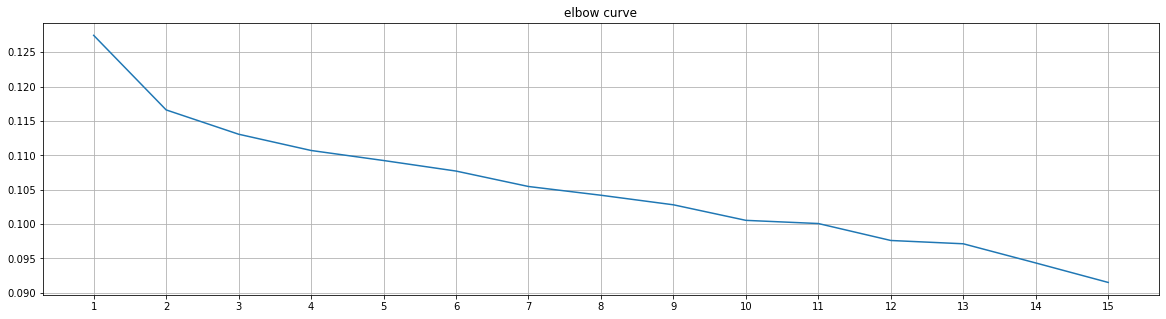

In [15]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

res = list()
n_cluster = range(1,16)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(germany_grouped_clustering)
    res.append(np.average(np.min(cdist(germany_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)))

fig = plt.figure(figsize=(20, 5))
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.xticks(np.arange(1, 16, step=1))
plt.grid(True)
plt.show()



We can also check the inertia which gives us the sum of intracluster distances (sum of distances of all the points within a cluster from the centroid of that cluster).

Text(0.5, 1.0, 'Elbow curve')

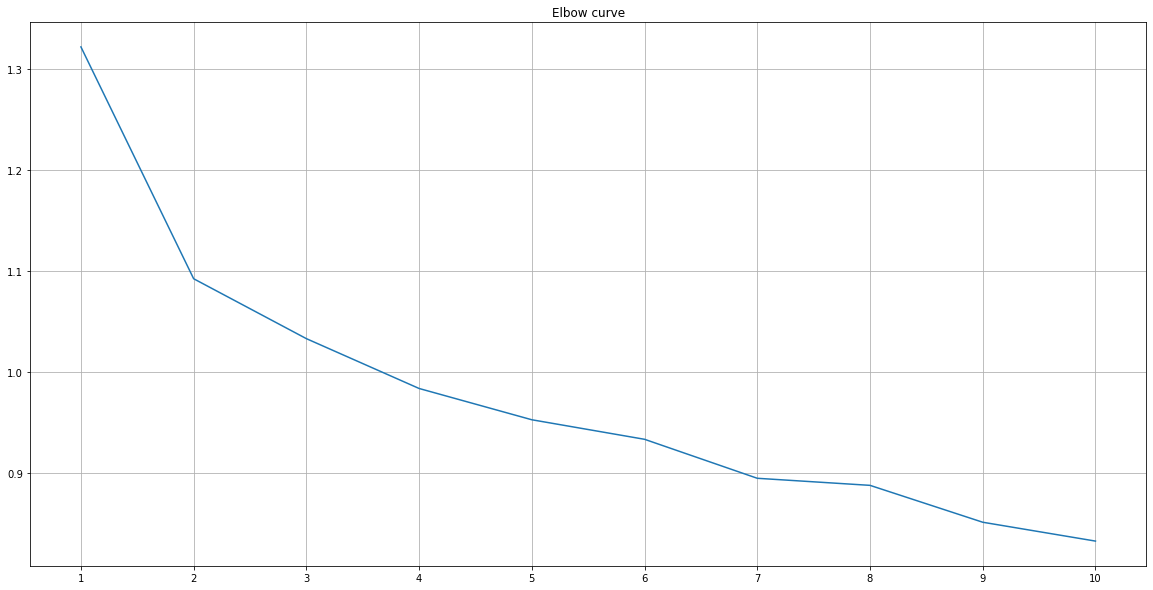

In [39]:

distorsions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(germany_grouped_clustering)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(20, 10))
plt.plot(range(1, 11), distorsions)
plt.grid(True)
plt.xticks(np.arange(1, 11, step=1))
plt.title('Elbow curve')  
    

We see an elbow at k=4 and go with the decision for 4 clusters. So let's process the clustering once again...

--------

In [36]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(germany_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

------
We merge the cluster labels to the dataframe with the most common values for each city

In [37]:
# add clustering labels
cities_venues_sorted['Cluster Labels'] = kmeans.labels_

germany_merged = df_2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
germany_merged = germany_merged.join(cities_venues_sorted.set_index('city'), on='city')

germany_merged.head()


,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Berlin,52.517037,13.388860,Coffee Shop,History Museum,Hotel,Monument / Landmark,Plaza,Bookstore,Concert Hall,Historic Site,Gourmet Shop,Drugstore,1
1,Hamburg,53.543764,10.009913,Hotel,Coffee Shop,Art Gallery,Plaza,Italian Restaurant,Vietnamese Restaurant,Clothing Store,Theater,Seafood Restaurant,Scenic Lookout,1
2,Munich,48.137108,11.575382,Café,Plaza,German Restaurant,Ice Cream Shop,Cocktail Bar,Coffee Shop,Hotel,Department Store,Bavarian Restaurant,Gourmet Shop,1
3,Cologne,50.938361,6.959974,Hotel,Plaza,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Bakery,Scenic Lookout,Cocktail Bar,Pedestrian Plaza,1
4,Frankfurt am Main,50.110644,8.682092,Café,Park,Bar,Plaza,Burger Joint,Italian Restaurant,Bakery,Art Museum,Apple Wine Pub,Coffee Shop,1


Let's plot the results on our map:

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat_ger, lng_ger], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(germany_merged['latitude'], germany_merged['longitude'], germany_merged['city'], germany_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can list the cities per cluster:

In [39]:
germany_merged.loc[germany_merged['Cluster Labels'] == 0,:]

,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
16,Wuppertal,51.264018,7.178037,Supermarket,Café,Clothing Store,Fast Food Restaurant,Plaza,Greek Restaurant,Multiplex,Bar,Gas Station,Korean Restaurant,0
24,Gelsenkirchen,51.511032,7.096012,Supermarket,Drugstore,Park,Bus Stop,Bakery,Fast Food Restaurant,Ice Cream Shop,Clothing Store,Light Rail Station,Music Venue,0
25,Mönchengladbach,51.194698,6.435364,Supermarket,Café,Gym / Fitness Center,Clothing Store,German Restaurant,Drugstore,Restaurant,Pizza Place,Hotel,Sandwich Place,0
27,Chemnitz,50.832261,12.925298,Supermarket,Drugstore,Asian Restaurant,Nightclub,Café,Sandwich Place,Ice Cream Shop,Hotel,Clothing Store,Bakery,0
33,Krefeld,51.333120,6.562334,Supermarket,Café,Drugstore,Clothing Store,Bakery,Italian Restaurant,Hotel,Ice Cream Shop,Plaza,Bank,0
35,Oberhausen,51.469614,6.851444,Supermarket,Drugstore,Gym / Fitness Center,Music Venue,Hotel,Bakery,Nightclub,Pub,Café,Bowling Alley,0
40,Hagen,51.358294,7.473296,Supermarket,Bakery,Clothing Store,Italian Restaurant,Doner Restaurant,Ice Cream Shop,Burger Joint,Sushi Restaurant,Drugstore,Bar,0
41,Hamm,51.680409,7.815197,Supermarket,Drugstore,Platform,Bakery,Fast Food Restaurant,German Restaurant,Hotel,Café,Gym / Fitness Center,Ice Cream Shop,0
43,Mülheim an der Ruhr,51.427293,6.882919,Supermarket,Hotel,Park,German Restaurant,Museum,Bakery,Nightclub,Italian Restaurant,Tram Station,Bar,0
45,Ludwigshafen am Rhein,49.470411,8.438157,Supermarket,Clothing Store,Hotel,Italian Restaurant,German Restaurant,Café,Nightclub,Shopping Mall,Bakery,Park,0


In [40]:
germany_merged.loc[germany_merged['Cluster Labels'] == 1,:]

,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Berlin,52.517037,13.388860,Coffee Shop,History Museum,Hotel,Monument / Landmark,Plaza,Bookstore,Concert Hall,Historic Site,Gourmet Shop,Drugstore,1
1,Hamburg,53.543764,10.009913,Hotel,Coffee Shop,Art Gallery,Plaza,Italian Restaurant,Vietnamese Restaurant,Clothing Store,Theater,Seafood Restaurant,Scenic Lookout,1
2,Munich,48.137108,11.575382,Café,Plaza,German Restaurant,Ice Cream Shop,Cocktail Bar,Coffee Shop,Hotel,Department Store,Bavarian Restaurant,Gourmet Shop,1
3,Cologne,50.938361,6.959974,Hotel,Plaza,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Bakery,Scenic Lookout,Cocktail Bar,Pedestrian Plaza,1
4,Frankfurt am Main,50.110644,8.682092,Café,Park,Bar,Plaza,Burger Joint,Italian Restaurant,Bakery,Art Museum,Apple Wine Pub,Coffee Shop,1
5,Stuttgart,48.778449,9.180013,Cocktail Bar,Plaza,Sushi Restaurant,German Restaurant,Bar,Italian Restaurant,Nightclub,Ice Cream Shop,Café,Theater,1
6,Düsseldorf,51.225402,6.776314,Coffee Shop,Café,Japanese Restaurant,Hotel,Park,Brewery,Plaza,Art Museum,Grocery Store,Ice Cream Shop,1
7,Dortmund,51.514227,7.465279,Café,Coffee Shop,Italian Restaurant,Pub,Ice Cream Shop,Turkish Restaurant,Restaurant,Salad Place,Plaza,Thai Restaurant,1
8,Essen,51.458224,7.015817,Café,Nightclub,Italian Restaurant,Theater,Restaurant,Hotel,Supermarket,Pub,Ice Cream Shop,Turkish Restaurant,1
9,Leipzig,51.340632,12.374733,Hotel,Zoo Exhibit,Café,Bistro,Bar,Bakery,Park,Chinese Restaurant,Plaza,Trattoria/Osteria,1


In [41]:
germany_merged.loc[germany_merged['Cluster Labels'] == 2,:]

,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels


In [35]:
germany_merged.loc[germany_merged['Cluster Labels'] == 3,:]

,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels


Let's have a look at the top venues per cluster:

In [43]:
print('Please insert Cluster [0,1,2 or 3]')
cluster=int(input())

a= germany_grouped.join(germany_merged.set_index('city'), on='city')
b=a.groupby('Cluster Labels').mean()
c=b.transpose()
c.drop(['latitude','longitude'], axis=0, inplace=True)
d=c.sort_values(by=cluster, ascending=False)
d.iloc[0:6,cluster]


Please insert Cluster [0,1,2 or 3]


 1


Café                  0.068638
Hotel                 0.044993
German Restaurant     0.039308
Italian Restaurant    0.039172
Plaza                 0.033224
Bar                   0.030889
Name: 1, dtype: float64

------
Let's validate our results and try a further method: hierarchial clustering.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


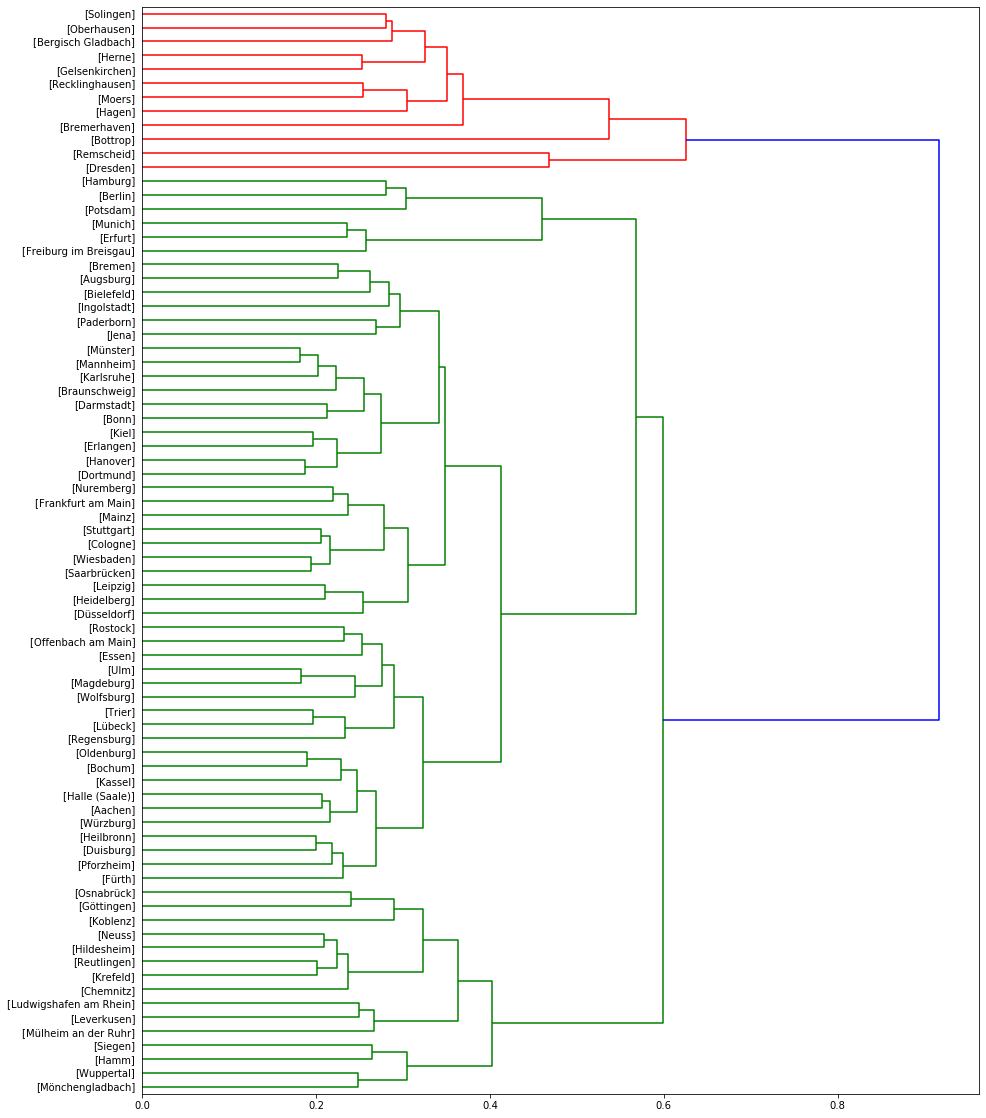

In [45]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

dist_matrix = distance_matrix(germany_grouped_clustering, germany_grouped_clustering) 
#print(dist_matrix)

def llf(id):
    return '[%s]' % (germany_grouped['city'][id])
    
Z = hierarchy.linkage(dist_matrix, 'complete')
plt.figure(figsize=(15,20))
dendro = hierarchy.dendrogram(Z, orientation='right', leaf_font_size=10, leaf_label_func=llf)

